# Filter grants by activity

This script shows how to pull out different grants by activity type.

## Read in and consolidate data

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


def ConsolidateGrantsData(SPI_grantsdata, MPI_primary_grantsdata, MPI_other_grantsdata):
    """
    This functions compiles the Single PI, Multi PI AAPM Primary, and Multi PI Other grants datasets into a single dataframe.
    """
    grantsdatasets = [SPI_grantsdata, MPI_primary_grantsdata, MPI_other_grantsdata]
    ConsolidatedGrantsData = pd.DataFrame([])
    count = 0
    for dataset in grantsdatasets:
        count = count + 1
        compiled = pd.DataFrame([])
        for key in dataset:
            if 'Sheet1' in key:
                pass
            else:
                year = pd.to_numeric(key)
                df = dataset[key]

                if year in np.arange(1985, 2009, 1):
                    df['FUNDING_MECHANISM'] = np.nan

                if year in np.arange(1985, 2015, 1):
                    df['DIRECT_COST_AMT'] = np.nan
                    df['INDIRECT_COST_AMT'] = np.nan

                if year in np.arange(1985, 2016, 1):
                    df['ORG_IPF_CODE'] = np.nan
                df['year'] = year
                df = df.sort_index(axis=1)
                compiled = pd.concat([compiled, df], ignore_index=True)

        if count == 1:
            compiled['Source_Data'] = 'SinglePI'
        elif count == 2:
            compiled['Source_Data'] = 'MultiPI_AAPMprimary'
        elif count == 3:
            compiled['Source_Data'] = 'MultiPI_Other'

        ConsolidatedGrantsData = pd.concat([ConsolidatedGrantsData, compiled], ignore_index=True)

    Grants_Data = ConsolidatedGrantsData
    return Grants_Data

# where is the data:
data_loc = Path(r'C:\Users\Brendan\Dropbox (Sydney Uni)\abstracts,presentations etc\MATLAB\AAPM_ResearchDatabase\ExtractedGrants')
single_PI_grants_loc = 'SinglePIgrants.xls'
multi_PI_grants_primary_loc = 'MultiPIgrantsPrimary.xls'
multi_PI_grants_other_loc = 'MultiPIgrantsOther.xls'

# read data into pandas:
single_PI_grants = pd.read_excel(data_loc / single_PI_grants_loc, sheet_name=None)
multi_PI_grants_primary = pd.read_excel(data_loc / multi_PI_grants_primary_loc, sheet_name=None)
multi_PI_grants_other = pd.read_excel(data_loc / multi_PI_grants_other_loc, sheet_name=None)
# join all grants together (if you want to)
all_grants = ConsolidateGrantsData(single_PI_grants, multi_PI_grants_primary, multi_PI_grants_other)

At this point, we have four different DataFrames:

1. single_PI_grants: grants with only one PI
2. multi_PI_grants_primary: Multiple PIs, but an AAPM member is the 'contact' PI
3. multi_PI_grants_other: Multiple PIs; the 'contact' PI is not an AAPM member

## Plot grants by activity

<Axes: ylabel='count'>

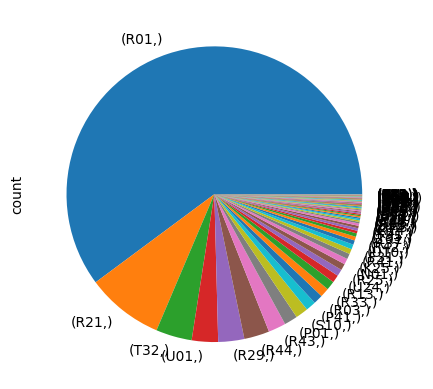

In [2]:
all_grants[['ACTIVITY']].value_counts().plot(kind='pie')

We can already see that there are a massive ammounts of different activity types listed, with the large majority being R01. Because this plot isn't **that** helpful, let's also print the activity types:

In [3]:
print(all_grants['ACTIVITY'].unique())

['R01' 'N01' 'S07' 'R23' 'R43' 'T32' 'U10' 'U01' 'R13' 'R03' 'F32' 'F05'
 'S10' 'S15' 'P01' 'R29' 'N44' 'P41' 'R44' 'F33' 'R55' 'R41' 'G08' 'K08'
 'N43' 'R42' 'R25' 'Z01' 'R21' 'T35' 'U24' 'P20' 'R24' 'U18' 'R33' 'K25'
 'F31' 'K01' 'G13' 'RC1' 'R56' 'P50' 'I01' 'T34' 'U54' 'R18' 'R15' 'U58'
 'K99' 'F30' 'K22' 'R00' 'I21' 'K07' 'R35' 'P30' 'UH2' 'R37' 'UG3' 'SC2'
 'RF1' 'UH3' 'K23' 'TL1' 'UF1' 'RC2' 'R61' 'UM1' 'U19' 'SB1']


## Filter grants by activity type

the following code snippet can be used to extract grants by activity type

In [4]:
# filter grants by different awards:
grants_to_filter = ['K99', 'K08', 'K22']
matching_grants_ind = np.zeros(all_grants.shape[0], dtype=bool)  # we will change to True whenever we find a matching grant type
for grant_type in grants_to_filter:
    _temp_ind = all_grants['ACTIVITY'] == grant_type
    matching_grants_ind = np.logical_or(matching_grants_ind, _temp_ind)
matching_grants = all_grants[matching_grants_ind]
print(f'total number of grants matching activity codes: {grants_to_filter}: {np.count_nonzero(matching_grants_ind)}')

total number of grants matching activity codes: ['K99', 'K08', 'K22']: 19


## Filter grants by activity type sub-string

In [5]:
# filter activites containing a given string
search_string = 'K'
matching_grants_ind = all_grants['ACTIVITY'].str.contains('K')
print(f'total number of grants matching activity codes: {search_string}: {np.count_nonzero(matching_grants_ind)}')
K_grants = all_grants[matching_grants_ind]

# filter activites containing a given string
search_string = 'R'
matching_grants_ind = all_grants['ACTIVITY'].str.contains('R')
print(f'total number of grants matching activity codes: {search_string}: {np.count_nonzero(matching_grants_ind)}')
R_grants = all_grants[matching_grants_ind]

total number of grants matching activity codes: K: 94
total number of grants matching activity codes: R: 6131


## Compare AAPM K grants with NIH

NIH provide some [useful data](https://report.nih.gov/nihdatabook/report/201) on the distribution of funded grant mechanisms. If you export this data to excel and put it in this directory (there's a button on the page) you can read in the data like this:

In [6]:
NIH_data = pd.read_excel('NDB_Report_ID_201_exp_05042023.xlsx',  header=2)

k_ind= []
for group in NIH_data.Subgroup:
    _k_ind = False
    if isinstance(group, str):
        if group[0] == 'K':
            _k_ind = True
    k_ind.append(_k_ind)

NIH_data_K_grants = NIH_data[k_ind]
NIH_data_K_grants = NIH_data_K_grants.drop(labels=['Mechanism'], axis=1)
NIH_data_K_grants = NIH_data_K_grants.drop(labels=['Subgroup'], axis=1)
NIH_years = list(NIH_data_K_grants.columns)
NIH_data_K_grants = NIH_data_K_grants.to_numpy()
NIH_data_K_grants= np.nansum(NIH_data_K_grants,axis=0)

r_ind= []
for group in NIH_data.Subgroup:
    _r_ind = False
    if isinstance(group, str):
        if group[0] == 'R' and not group[1]=='e':
            _r_ind = True
    r_ind.append(_r_ind)

NIH_data_R_grants = NIH_data[r_ind]
NIH_data_R_grants = NIH_data_R_grants.drop(labels=['Mechanism'], axis=1)
NIH_data_R_grants = NIH_data_R_grants.drop(labels=['Subgroup'], axis=1)
NIH_data_R_grants = NIH_data_R_grants.to_numpy()
NIH_data_R_grants = np.nansum(NIH_data_R_grants,axis=0)

I also want to process the AAPM data a bit more to get it in a comparable format

In [7]:
year_ind = R_grants.year >= 1997  # match NIH reporting
R_grants = R_grants[year_ind]
years = np.unique(R_grants.year)
n_R_grants = []
for year in years:
    ind = R_grants.year == year
    n_R_grants.append(np.count_nonzero(ind))

year_ind = K_grants.year >= 1997  # match NIH reporting
K_grants = K_grants[year_ind]
n_k_grants = []
for year in years:
    ind = K_grants.year == year
    n_k_grants.append(np.count_nonzero(ind))
    

    

## Plot K grants versus R grants:

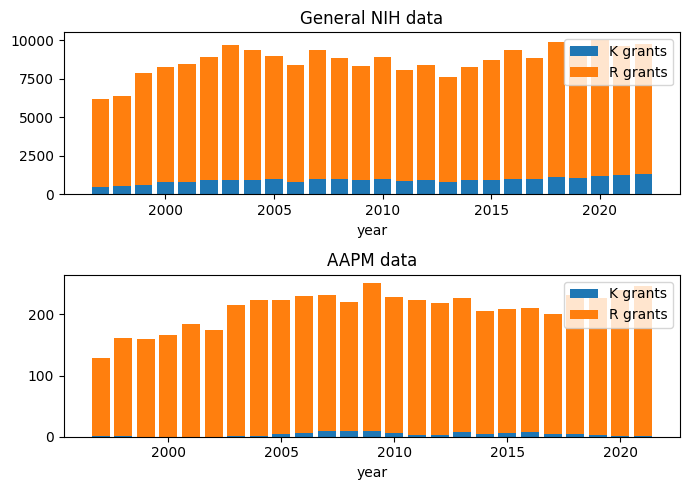

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[7, 5])
bottom = np.zeros(len(NIH_years))
p = ax[0].bar(NIH_years, NIH_data_K_grants, bottom=bottom, label='K grants')
bottom = bottom + NIH_data_K_grants
p = ax[0].bar(NIH_years, NIH_data_R_grants, bottom=bottom, label = 'R grants')
ax[0].set_xlabel('year')
ax[0].legend(loc="upper right")
ax[0].set_title('General NIH data')


bottom = np.zeros(len(years))
p = ax[1].bar(years, n_k_grants, bottom=bottom, label='K grants')
bottom = bottom + n_k_grants
p = ax[1].bar(years, n_R_grants, bottom=bottom, label = 'R grants')
ax[1].set_xlabel('year')
ax[1].legend(loc="upper right")
ax[1].set_title('AAPM data')

plt.tight_layout()
plt.show()
